### Подключение к базе и основные таблицы

In [3]:
import pandas as pd

### Данные по пользователям

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [4]:
### Посты и топики

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [5]:
### Почти 77 миллионов записей, многовато!
### Не в каждую оперативу влезет столько данных
### Для обучения моделей

count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

count_feed_data.head()

,count
0,76892800


In [6]:
### Попробуем забрать, скажем, 10 миллионов

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-07 07:04:38,16739,1798,view,0
1,2021-11-07 07:06:44,16739,7232,view,0
2,2021-11-07 07:08:59,16739,1517,view,0
3,2021-11-07 07:09:26,16739,3849,view,0
4,2021-11-07 07:10:17,16739,1527,view,0


### Работа с данными и фичи для контентной модели

In [7]:
### Как устроена колонка target?

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
10,2021-11-07 07:18:25,16739,3070,like,0
28,2021-11-08 15:53:24,16739,5093,like,0
30,2021-11-08 15:55:05,16739,2589,like,0
41,2021-10-31 15:27:59,67441,1661,like,0
47,2021-10-31 15:36:01,67441,931,like,0
...,...,...,...,...,...
9999910,2021-10-03 06:51:17,138957,1385,like,0
9999937,2021-10-17 07:00:14,138957,3310,like,0
9999944,2021-10-17 07:11:06,138957,1474,like,0
9999975,2021-10-23 22:01:20,138957,6076,like,0


In [8]:
### Почистим данные от action != view

feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-07 07:04:38,16739,1798,view,0
1,2021-11-07 07:06:44,16739,7232,view,0
2,2021-11-07 07:08:59,16739,1517,view,0
3,2021-11-07 07:09:26,16739,3849,view,0
4,2021-11-07 07:10:17,16739,1527,view,0


Напомним, как устроен контентный подход! 

Научимся по выбранной дате timestamp 

И для любой пары (user_id, post_id)

Предсказывать, случится лайк или нет

Хорошо бы иметь модель, которая умеет предсказывать вероятности

In [9]:
### Необходимо по user_id выделять 
### Фиксированный набор признаков
### В целом, подойдет оригинальный датасет

user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [10]:
### C post_id куда интереснее!
### Придумаем какой-нибудь эмбеддинг 
### Для текстов

posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [14]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [20]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
### Генерим фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [23]:
[f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

['DistanceTo1thCluster',
 'DistanceTo2thCluster',
 'DistanceTo3thCluster',
 'DistanceTo4thCluster',
 'DistanceTo5thCluster',
 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster']

In [24]:
### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.531306,0.462755,0.481181,0.440688,0.392935,0.575248,0.439882,0.544286,0.430978,0.214297,0.460067,0.527110,0.467981,0.442593,0.507264
1,0.423759,0.327151,0.344161,0.293637,0.190519,0.333536,0.289404,0.448235,0.161516,0.234693,0.304486,0.413277,0.340088,0.299045,0.381583
2,0.445623,0.354515,0.365523,0.314599,0.232483,0.527190,0.313437,0.483647,0.340239,0.099657,0.347924,0.433253,0.349477,0.330202,0.396769
3,0.408890,0.292552,0.323325,0.255180,0.156971,0.483837,0.259839,0.447184,0.268916,0.156913,0.291093,0.386724,0.308510,0.292548,0.359402
4,0.402261,0.231886,0.264687,0.162456,0.075114,0.452792,0.172365,0.400380,0.223737,0.237734,0.248597,0.344308,0.249565,0.227240,0.304376


In [25]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,9,0.531306,0.462755,0.481181,...,0.575248,0.439882,0.544286,0.430978,0.214297,0.460067,0.527110,0.467981,0.442593,0.507264
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,8,0.423759,0.327151,0.344161,...,0.333536,0.289404,0.448235,0.161516,0.234693,0.304486,0.413277,0.340088,0.299045,0.381583
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,9,0.445623,0.354515,0.365523,...,0.527190,0.313437,0.483647,0.340239,0.099657,0.347924,0.433253,0.349477,0.330202,0.396769
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.408890,0.292552,0.323325,...,0.483837,0.259839,0.447184,0.268916,0.156913,0.291093,0.386724,0.308510,0.292548,0.359402
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,4,0.402261,0.231886,0.264687,...,0.452792,0.172365,0.400380,0.223737,0.237734,0.248597,0.344308,0.249565,0.227240,0.304376


In [26]:
### Воспроизведем датафрейм со всеми новыми фичами 

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-11-07 07:04:38,16739,1798,view,0,Wenger rules out new keeper\n\nArsenal boss Ar...,sport,7.925957,0.575346,0.000172,...,0.474059,0.229067,0.415025,0.268640,0.307663,0.319000,0.388741,0.282686,0.116522,0.340739
1,2021-11-07 07:06:44,16739,7232,view,0,"This movie is very difficult to understand, wh...",movie,7.291683,0.297143,0.000159,...,0.514873,0.159560,0.453368,0.326810,0.362920,0.354909,0.404080,0.152375,0.288871,0.136181
2,2021-11-07 07:08:59,16739,1517,view,0,Campbell lifts lid on United feud\n\nArsenals ...,sport,10.092160,0.319242,0.000219,...,0.490555,0.248492,0.415943,0.309822,0.345748,0.360218,0.421485,0.277885,0.131334,0.347923
3,2021-11-07 07:09:26,16739,3849,view,0,CSK squad member told that theyre in a complet...,covid,3.470843,0.422975,0.000075,...,0.470350,0.159152,0.405154,0.249748,0.296009,0.309843,0.284151,0.240139,0.222036,0.301544
4,2021-11-07 07:10:17,16739,1527,view,0,Player burn-out worries Robinson\n\nEngland co...,sport,6.644078,0.508859,0.000144,...,0.573504,0.364497,0.514759,0.402773,0.441657,0.437418,0.485219,0.402265,0.237053,0.435469


In [27]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-11-07 07:04:38,16739,1798,view,0,Wenger rules out new keeper\n\nArsenal boss Ar...,sport,7.925957,0.575346,0.000172,...,0.282686,0.116522,0.340739,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads
1,2021-11-07 07:06:44,16739,7232,view,0,"This movie is very difficult to understand, wh...",movie,7.291683,0.297143,0.000159,...,0.152375,0.288871,0.136181,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads
2,2021-11-07 07:08:59,16739,1517,view,0,Campbell lifts lid on United feud\n\nArsenals ...,sport,10.092160,0.319242,0.000219,...,0.277885,0.131334,0.347923,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads
3,2021-11-07 07:09:26,16739,3849,view,0,CSK squad member told that theyre in a complet...,covid,3.470843,0.422975,0.000075,...,0.240139,0.222036,0.301544,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads
4,2021-11-07 07:10:17,16739,1527,view,0,Player burn-out worries Robinson\n\nEngland co...,sport,6.644078,0.508859,0.000144,...,0.402265,0.237053,0.435469,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads


In [28]:
### А еще научимся выделять признаки
### Из timestamp!
### Согласитесь, от времени просмотра может зависеть
### Склонность пользователей лайкать или игнорировать посты

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-11-07 07:04:38,16739,1798,view,0,Wenger rules out new keeper\n\nArsenal boss Ar...,sport,7.925957,0.575346,0.000172,...,0.340739,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads,7,11
1,2021-11-07 07:06:44,16739,7232,view,0,"This movie is very difficult to understand, wh...",movie,7.291683,0.297143,0.000159,...,0.136181,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads,7,11
2,2021-11-07 07:08:59,16739,1517,view,0,Campbell lifts lid on United feud\n\nArsenals ...,sport,10.092160,0.319242,0.000219,...,0.347923,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads,7,11
3,2021-11-07 07:09:26,16739,3849,view,0,CSK squad member told that theyre in a complet...,covid,3.470843,0.422975,0.000075,...,0.301544,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads,7,11
4,2021-11-07 07:10:17,16739,1527,view,0,Player burn-out worries Robinson\n\nEngland co...,sport,6.644078,0.508859,0.000144,...,0.435469,0,17,Russia,Yuzhno-Sukhokumsk,3,iOS,ads,7,11


In [29]:
### Уберем все ненужные колонки

df = df.drop([
#    'timestamp',  ### timestamp пока оставим
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
16739   1798    2021-11-07 07:04:38       0          sport    7.925957   
        7232    2021-11-07 07:06:44       0          movie    7.291683   
        1517    2021-11-07 07:08:59       0          sport   10.092160   
        3849    2021-11-07 07:09:26       0          covid    3.470843   
        1527    2021-11-07 07:10:17       0          sport    6.644078   
        1880    2021-11-07 07:12:39       0          sport    6.801673   
        5058    2021-11-07 07:14:52       0          movie    5.963746   
        1518    2021-11-07 07:16:12       0          sport    7.719683   
        3336    2021-11-07 07:17:24       0          covid    3.149626   
        3070    2021-11-07 07:17:53       1          covid    3.110271   
        5419    2021-11-07 07:18:27       0          movie    8.469215   
        4990    2021-11-07 07:19:24       0          movie    5.551446   
        2832    2021-11-07 07:20:22       0          covid    3.322638   
        5239    2021-11-07 07:22:44       0          movie   12.004614   
        967     2021-11-07 07:25:24       0       politics    7.696906   
        4753    2021-11-07 07:26:35       0          movie    9.261060   
        6129    2021-11-07 07:27:03       0          movie    8.128977   
        5831    2021-11-07 07:27:45       0          movie    7.101997   
        236     2021-11-07 07:29:36       0       business    8.090172   
        4666    2021-11-07 07:31:10       0          movie    6.520485   
        6081    2021-11-07 07:32:17       0          movie   10.675143   
        3549    2021-11-07 07:33:04       0          covid    2.860757   
        850     2021-11-07 07:34:58       0  entertainment   10.387538   
        4672    2021-11-07 07:37:46       0          movie    5.624706   
        4131    2021-11-07 07:39:38       0          covid    2.905578   
        4005    2021-11-07 07:42:01       0          covid    3.186704   
        5093    2021-11-08 15:52:26       1          movie    6.977583   
        2589    2021-11-08 15:53:26       1          covid    3.503165   
        1361    2021-11-08 15:55:07       0       politics   11.013595   
        4862    2021-11-08 15:56:13       0          movie    6.443389   
        7222    2021-11-08 15:56:42       0          movie    6.615543   
        1803    2021-11-08 15:58:46       0          sport    9.455023   
        4794    2021-11-08 16:00:22       0          movie    7.532169   
        6238    2021-11-08 16:01:57       0          movie   12.066194   
        1146    2021-11-08 16:04:21       0       politics   10.858279   
        1427    2021-11-08 16:06:47       0          sport    9.747680   
        1295    2021-11-08 16:08:06       1       politics    9.798157   
67441   1661    2021-10-31 15:26:40       1          sport   11.140378   
        2217    2021-10-31 15:28:01       0           tech    9.392150   
        2761    2021-10-31 15:30:25       0          covid    2.977023   
        1578    2021-10-31 15:32:07       0          sport    7.214194   
        399     2021-10-31 15:33:14       0       business    9.069914   
        931     2021-10-31 15:33:24       1  entertainment    8.325652   
        244     2021-10-31 15:36:03       0       business    9.543331   
        394     2021-10-31 15:38:44       1       business   10.956958   
        7023    2021-10-31 15:39:46       0          movie    8.339866   
        6445    2021-10-31 15:41:12       0          movie   11.472287   
        7054    2021-10-31 15:43:20       0          movie    9.109638   
        522     2021-10-31 15:43:57       0       business    8.202848   
        6213    2021-10-31 15:45:13       0          movie    5.736053   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
16739   1798     0.575346  

### Пора обучать модели! 

In [30]:
### Предлагаю начать с относительно простой модели
### Например, с решающего дерева
### А потом посмотреть уже в сторону бустингов

### Как валидировать? Как разобьем на train и test?
### Предлагаю по времени, так как данные имеют 
### Временную структуру! Хотим корректно оценивать
### Вероятности для будущих рекомендаций

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:44:39'), Timestamp('2021-10-01 06:02:14'))

In [31]:
### За отсечку возьмем 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((7457924,), (1479736,))

In [32]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                        
16739   1798     sport    7.925957  0.575346   0.000172           13   
        7232     movie    7.291683  0.297143   0.000159           14   
        1517     sport   10.092160  0.319242   0.000219           13   
        3849     covid    3.470843  0.422975   0.000075            3   
        1527     sport    6.644078  0.508859   0.000144           13   
...                ...         ...       ...        ...          ...   
138957  4684     movie    6.592652  0.442155   0.000143           12   
        7168     movie   10.489737  0.191404   0.000228            2   
        5899     movie    6.036753  0.328887   0.000131            6   
        7084     movie   10.431519  0.309577   0.000227            6   
        4224     movie   11.920504  0.432583   0.000259            2   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
16739   1798                 0.444000              0.285958   
        7232                 0.458323              0.312433   
        1517                 0.462522              0.328750   
        3849                 0.437225              0.140527   
        1527                 0.515741              0.410728   
...                               ...                   ...   
138957  4684                 0.453241              0.292155   
        7168                 0.462650              0.282596   
        5899                 0.418882              0.249596   
        7084                 0.488200              0.363660   
        4224                 0.447079              0.305746   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
16739   1798                 0.304388              0.245415   
        7232                 0.236432              0.274217   
        1517                 0.317506              0.292245   
        3849                 0.261079              0.046361   
        1527                 0.414792              0.379635   
...                               ...                   ...   
138957  4684                 0.266047              0.231340   
        7168                 0.111432              0.228990   
        5899                 0.248174              0.187281   
        7084                 0.254551              0.330537   
        4224                 0.121700              0.270179   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
16739   1798                 0.186712  ...               0.340739       0   
        7232                 0.267369  ...               0.136181       0   
        1517                 0.239158  ...               0.347923       0   
        3849                 0.162998  ...               0.301544       0   
        1527                 0.355604  ...               0.435469       0   
...                               ...  ...                    ...     ...   
138957  4684                 0.233902  ...               0.265285       0   
        7168                 0.233468  ...               0.298136       0   
        5899                 0.158317  ...               0.242734       0   
        7084                 0.313442  ...               0.226714       0   
        4224                 0.240440  ...               0.296543       0   

                 age  country               city  exp_group       os   source  \
user_id post_id                                                                 
16739   1798      17   Russia  Yuzhno-Sukhokumsk          3      iOS      ads   
        7232      17   Russia  Yuzhno-Sukhokumsk          3      iOS      ads   
        1517      17   Russia  Yuzhno-Sukhokumsk          3      iOS      ads   
        3849      17   Russia  Yu

In [33]:
### Начнем с решающего дерева!

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

### Cохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

c:\Users\grokh\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\grokh\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
c:\Users\grokh\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [34]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9035159187063293
Качество на тесте: 0.5382148986507512


In [35]:
### Теперь обучим катбуст!

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3549979	total: 2.52s	remaining: 4m 9s
1:	learn: 0.3480111	total: 4.75s	remaining: 3m 52s
2:	learn: 0.3468019	total: 6.8s	remaining: 3m 40s
3:	learn: 0.3460611	total: 8.72s	remaining: 3m 29s
4:	learn: 0.3458798	total: 10.4s	remaining: 3m 16s
5:	learn: 0.3457456	total: 12.2s	remaining: 3m 11s
6:	learn: 0.3456490	total: 13.9s	remaining: 3m 4s
7:	learn: 0.3453602	total: 15.7s	remaining: 3m
8:	learn: 0.3453164	total: 17.3s	remaining: 2m 55s
9:	learn: 0.3447169	total: 19.5s	remaining: 2m 55s
10:	learn: 0.3446779	total: 21.4s	remaining: 2m 53s
11:	learn: 0.3443240	total: 23.6s	remaining: 2m 53s
12:	learn: 0.3440330	total: 25.7s	remaining: 2m 52s
13:	learn: 0.3440039	total: 27.6s	remaining: 2m 49s
14:	learn: 0.3439777	total: 29.5s	remaining: 2m 46s
15:	learn: 0.3439523	total: 31.2s	remaining: 2m 43s
16:	learn: 0.3438443	total: 32.8s	remaining: 2m 40s
17:	learn: 0.3438199	total: 34.3s	remaining: 2m 36s
18:	learn: 0.3438024	total: 35.8s	remaining: 2m 32s
19:	learn: 0.3437282	total: 3

In [36]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6652934417963365
Качество на тесте: 0.6474842748247901


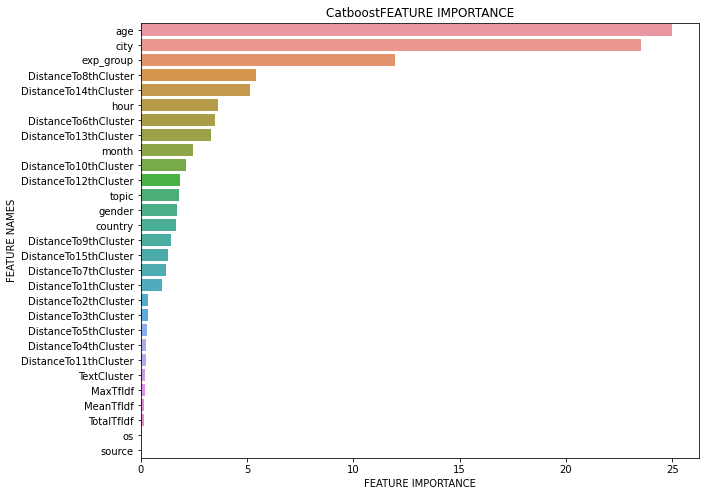

In [37]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [38]:
### Сохраним модель

catboost.save_model(
    'catboost_model',
    format="cbm"                  
)

### Положим в базу фичи, необходимые для функционала нашей модели

In [39]:
posts_info.to_sql(    
   "posts_info_features",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   )                               
                                   

23

In [40]:
### Все ли норм?

test_ = pd.read_sql(
    """SELECT * FROM public.posts_info_features""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_

,index,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,9,0.531306,0.462755,...,0.575248,0.439882,0.544286,0.430978,0.214297,0.460067,0.527110,0.467981,0.442593,0.507264
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,8,0.423759,0.327151,...,0.333536,0.289404,0.448235,0.161516,0.234693,0.304486,0.413277,0.340088,0.299045,0.381583
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,9,0.445623,0.354515,...,0.527190,0.313437,0.483647,0.340239,0.099657,0.347924,0.433253,0.349477,0.330202,0.396769
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.408890,0.292552,...,0.483837,0.259839,0.447184,0.268916,0.156913,0.291093,0.386724,0.308510,0.292548,0.359402
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,4,0.402261,0.231886,...,0.452792,0.172365,0.400380,0.223737,0.237734,0.248597,0.344308,0.249565,0.227240,0.304376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,10.326422,0.300231,0.000224,14,0.589431,0.495972,...,0.617639,0.385493,0.575763,0.485697,0.519015,0.506248,0.562887,0.346470,0.469867,0.241993
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.258412,0.000146,14,0.499365,0.373173,...,0.544604,0.257067,0.492936,0.378921,0.419118,0.407604,0.449589,0.168933,0.353058,0.135458
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122,2,0.453069,0.280760,...,0.508190,0.163081,0.401581,0.316472,0.355665,0.341235,0.380635,0.196298,0.286206,0.288882
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150,12,0.467571,0.324185,...,0.500531,0.203070,0.365577,0.324869,0.358508,0.354120,0.411874,0.157854,0.301162,0.299081
